# BERT Classifier

Use Yujia's BERT classifier code with all the new data we got.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Packages-and-Load-Data" data-toc-modified-id="Import-Packages-and-Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Packages and Load Data</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Prepare-GPU" data-toc-modified-id="Prepare-GPU-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Prepare GPU</a></span></li></ul></li><li><span><a href="#Data-Pre-Processing" data-toc-modified-id="Data-Pre-Processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Pre-Processing</a></span><ul class="toc-item"><li><span><a href="#BERT-Tokenizer-and-Padding" data-toc-modified-id="BERT-Tokenizer-and-Padding-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>BERT Tokenizer and Padding</a></span></li><li><span><a href="#Attention-Masks" data-toc-modified-id="Attention-Masks-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Attention Masks</a></span></li></ul></li><li><span><a href="#Prepare-Model" data-toc-modified-id="Prepare-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare Model</a></span><ul class="toc-item"><li><span><a href="#Train-Test-Validation-Split" data-toc-modified-id="Train-Test-Validation-Split-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Train Test Validation Split</a></span></li><li><span><a href="#Multilabel-Classifier" data-toc-modified-id="Multilabel-Classifier-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Multilabel Classifier</a></span></li></ul></li><li><span><a href="#Run-Model" data-toc-modified-id="Run-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Run Model</a></span></li><li><span><a href="#Save-Trained-Models" data-toc-modified-id="Save-Trained-Models-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Save Trained Models</a></span></li></ul></div>

In [1]:
batch_size=4
gpu_id=1
epochs = 8
# topics = topic_to_id.keys()
topics = ['child product', 'pregnancy', 'dad parenting', 'multiple children', 'mom health', 'non-biological parents', 'child appearances']

In [2]:
# device = torch.device(1)
# if device.type == 'cuda':
#     print(torch.cuda.get_device_name(torch.cuda.current_device()))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

## Import Packages and Load Data

Can be later changed to pull data from GitHub, but for now just do it from a local path.

In [3]:
# Input data files are available in the "../data/" directory.
import os
print(os.listdir("../data"))

# Basics + Viz
import torch
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pre-processing
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

# Models
from sklearn.model_selection import train_test_split

from utils import flat_accuracy, format_time, single_topic_train, augmented_validationloader

['20200422-multilabel.h5', '.ipynb_checkpoints', 'facebook', '0527_reddit_1300_parenting_clean.csv', 'extra_data', 'labeled_only-reddit_796_of_1300.h5', '20200405-topic_to_id.pickle', '20200405-topic_per_row.h5']


Using TensorFlow backend.


### Load Data

In [4]:
# load dictionary
with open("../data/20200405-topic_to_id.pickle", "rb") as input_file:
    topic_to_id = pickle.load(input_file)

# load data
data_folder = '../data/extra_data/aug/'
df = pd.DataFrame()
file_names = os.listdir(data_folder)

for f in file_names:
    temp = pd.read_csv(data_folder + f)
    print(temp.shape)
    df = pd.concat([df, temp])

print(f"Total: {df.shape}")

(259, 33)
(665, 33)
(59, 33)
(590, 33)
(796, 33)
(249, 33)
Total: (2618, 33)


### Prepare GPU 

In [5]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device(gpu_id)

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(torch.cuda.current_device()))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


## Data Pre-Processing

Use https://github.com/huggingface/transformers BERTTokenizer to change all the words into IDs.

### BERT Tokenizer and Padding

In [6]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [7]:
# Set the maximum sequence length.
MAX_LEN = 512

sentence_lengths = []
def tokenize_and_count(s, lst, max_len):
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    answer = tokenizer.encode(s, add_special_tokens=True)
    lst.append(len(answer))
    
    return answer

df['bert'] = df.text.apply(lambda s : tokenize_and_count(s, sentence_lengths, MAX_LEN))
df['bert_aug'] = df.aug.apply(lambda s : tokenize_and_count(s, sentence_lengths, MAX_LEN))

Token indices sequence length is longer than the specified maximum sequence length for this model (601 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (580 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (835 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (662 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (846 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (623 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1082 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (562 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

It's obvious the default MAX_LEN=512 is not enough for some posts, but just how long are these posts?<br>
<br>
Turns out only 2% of all the sentences are above the length 512.<br>
So we'll just proceed as normal and truncate/extend all the sentences to length 512, as most sentences are distributed between the 100~200 word range, we don't want to add too many padding to most sentences by setting the MAX_LEN to something too high.

In [8]:
max_len = 512
temp = np.array(sentence_lengths)
temp_count = len(temp[temp > max_len])
temp_len = len(sentence_lengths)

print(f"Out of the\n{temp_len} total sentences,\n{temp_count} are over the length {max_len},\nTotal of: {(temp_count/temp_len * 100):.2f}%")

Out of the
5236 total sentences,
55 are over the length 512,
Total of: 1.05%


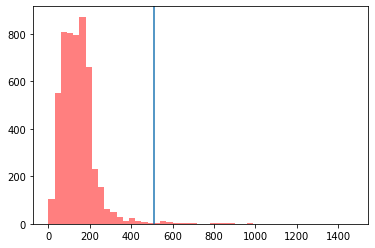

In [9]:
n, bins, patches = plt.hist(sentence_lengths, bins=[30 * i for i in range(50)], facecolor='red', alpha=0.5)
_ = plt.axvline(512)

In [10]:
# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
df['bert'] = pad_sequences(df['bert'].values, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post").tolist()
df['bert_aug'] = pad_sequences(df['bert_aug'].values, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post").tolist()

### Attention Masks

Source: https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
<br>
Attention masks are used to filter out the padding from each sentence. A simple format of 1 for a real word and 0 for padding.

In [11]:
# Create attention masks
df['attention'] = df['bert'].apply(lambda arr : [int(token_id > 0) for token_id in arr])
df['attention_aug'] = df['bert_aug'].apply(lambda arr : [int(token_id > 0) for token_id in arr])

## Prepare Model

### Train Test Validation Split

In [12]:
test_size = 0.2
validation_size = 0.5
train_df, test_df = train_test_split(df, random_state=42, test_size=test_size)
test_df, validation_df = train_test_split(test_df, random_state=42, test_size=validation_size)

print(f"""{1 - test_size}/{test_size * (1-validation_size)}/{test_size * validation_size} split
{train_df.shape[0]} lines of training data,
{test_df.shape[0]} lines of test data
{validation_df.shape[0]} lines of validation data""")

0.8/0.1/0.1 split
2094 lines of training data,
262 lines of test data
262 lines of validation data


### Multilabel Classifier
__[TODO]__ Turns out this is harder to do. Figure this out later.

For this classifier we are going to throw in all 30 labels as one big multilabel.<br>
This is happening first mostly because it's easier to implement.

## Run Model

Run all the training for the topics we want to run.<br>
Later, when we are sure of the model we're to use, we'll be running it for all 30 topics.

In [13]:
lrs = [5e-5, 3e-5, 2e-5]

for lr in lrs:
    avg_f1s = np.zeros(epochs, dtype=float)

    # Create x, y for each
    for topic in topics[::-1]:
        train_dataloader, test_dataloader, validation_dataloader = augmented_validationloader(train_df,
                                                                                              test_df,
                                                                                              validation_df,
                                                                                              topic,
                                                                                              batch_size)

        # Then load the pretrained BERT model (has linear classification layer on top)
        model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
            num_labels = 2, # The number of output labels--2 for binary classification.
                            # You can increase this for multi-class tasks.   
            output_attentions = False, # Whether the model returns attentions weights.
            output_hidden_states = False, # Whether the model returns all hidden-states.
        )

        model.cuda(device=device)

        # load optimizer
        optimizer = AdamW(model.parameters(),
                      lr = lr, # args.learning_rate - default is 5e-5
                      eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                    )

        # Total number of training steps is [number of batches] x [number of epochs]. 
        total_steps = len(train_dataloader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0,
                                                    num_training_steps = total_steps)

        arg_dict = {
            "device" : device,
            "optimizer" : optimizer,
            "scheduler" : scheduler,
            "model" : model,
            "epochs" : epochs,
            "train_dataloader" : train_dataloader,
            "test_dataloader" : validation_dataloader,
            "seed_val" : 42,
            "get_f1s" : True,
            "verbose" : False
        }
        model, train_losses, test_losses, f1s = single_topic_train(**arg_dict)
        avg_f1s += np.array(f1s)
    print(f"lr = {lr}: {(avg_f1s / len(topics)).tolist()}")

lr = 5e-05: [0.08048289738430583, 0.20547935773499684, 0.3216135952708843, 0.5200226244343892, 0.5200214822771213, 0.5113378684807256, 0.5672900199215989, 0.5602143887858173]
lr = 3e-05: [0.07589285714285714, 0.2802099835367937, 0.5239240140500645, 0.6545634643638273, 0.6899132446500869, 0.6846849245830571, 0.6862301217335143, 0.6884976954296594]
lr = 2e-05: [0.10860484544695072, 0.42453606151085144, 0.5594092182327477, 0.7194470278229869, 0.7149276383099796, 0.7079735740450027, 0.7281931836279661, 0.7142474809141477]


In [15]:
lrs = [1e-5, 5e-6]

for lr in lrs:
    avg_f1s = np.zeros(epochs, dtype=float)

    # Create x, y for each
    for topic in topics[::-1]:
        train_dataloader, test_dataloader, validation_dataloader = augmented_validationloader(train_df,
                                                                                              test_df,
                                                                                              validation_df,
                                                                                              topic,
                                                                                              batch_size)

        # Then load the pretrained BERT model (has linear classification layer on top)
        model = BertForSequenceClassification.from_pretrained(
            "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
            num_labels = 2, # The number of output labels--2 for binary classification.
                            # You can increase this for multi-class tasks.   
            output_attentions = False, # Whether the model returns attentions weights.
            output_hidden_states = False, # Whether the model returns all hidden-states.
        )

        model.cuda(device=device)

        # load optimizer
        optimizer = AdamW(model.parameters(),
                      lr = lr, # args.learning_rate - default is 5e-5
                      eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                    )

        # Total number of training steps is [number of batches] x [number of epochs]. 
        total_steps = len(train_dataloader) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0,
                                                    num_training_steps = total_steps)

        arg_dict = {
            "device" : device,
            "optimizer" : optimizer,
            "scheduler" : scheduler,
            "model" : model,
            "epochs" : epochs,
            "train_dataloader" : train_dataloader,
            "test_dataloader" : validation_dataloader,
            "seed_val" : 42,
            "get_f1s" : True,
            "verbose" : False
        }
        model, train_losses, test_losses, f1s = single_topic_train(**arg_dict)
        avg_f1s += np.array(f1s)
    print(f"lr = {lr}: {(avg_f1s / len(topics)).tolist()}")

lr = 1e-05: [0.06516290726817042, 0.24675324675324675, 0.5842891002554867, 0.6294093705858411, 0.6860166288737718, 0.7122598430869107, 0.7346648060933775, 0.7492931353690847]
lr = 5e-06: [0.06896551724137931, 0.15912087912087913, 0.24770044770044766, 0.4942900237017884, 0.5530499848910312, 0.5631834281540739, 0.6011988011988011, 0.6061115355233001]


## Save Trained Models

In [14]:
# # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# output_dir = './{}_model_save/'.format("child_product".replace(' ', '_'))
# print(output_dir)
# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# print("Saving model to %s" % output_dir)

# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
# # They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

# # Good practice: save your training arguments together with the trained model
# # torch.save(args, os.path.join(output_dir, 'training_args.bin'))